In [1]:
import numpy as np
import eduHF

# 1. Define a Molecule

A molecule is build out of different atoms. Atoms can be initiated by their respective atom type and the position in three-dimensional space (using atomic units of course)

In [2]:
H = eduHF.Atom('H', np.array([0.0, 0.0, 0.0]))
F = eduHF.Atom('F', np.array([1.74, 0.0, 0.0]))

Next, we initiated the molecule with a list of all the atoms and its charge. A negative charge leads to an anion, a positive to a cation.

In [3]:
HF = eduHF.Molecule([H, F], charge=0)

# 2. Define a Basis

We first define a dictionary containing the atom types as keys. The items are a list of tuples. Every tuple represents a Slater Function. The tuples contain first the type of function (i.e., `1s`, or `2p`) and second the exponent (often called $\zeta$ (zeta))

In [4]:
# Standard STO-3G exponents
# see Szabo, Ostlund - Modern Quantum Chemistry
# p. 186, table 3.8
base = {'H' : [('1s', 1.24)],
        'Li': [('1s', 2.69), ('2s', 0.75)],
        'Be': [('1s', 3.68), ('2s', 1.10)],
        'B' : [('1s', 4.68), ('2s', 1.45), ('2p', 1.45)],
        'C' : [('1s', 5.67), ('2s', 1.72), ('2p', 1.72)],
        'N' : [('1s', 6.67), ('2s', 1.95), ('2p', 1.95)],
        'O' : [('1s', 7.66), ('2s', 2.25), ('2p', 2.25)],
        'F' : [('1s', 8.65), ('2s', 2.55), ('2p', 2.55)],
        }

Now we build the basis set and apply it to the molecule. Wenn initiating the `Basis` we need to state the number of Gaussian functions which expand a single Slater function (parameter `ng`).

In [5]:
basisset = eduHF.BasisSet(base)
basis = eduHF.Basis(HF, basisset, ng=3)

# 3. Run the SCF

Next we initate the SCF with the molecule and the basis and prepare the integrals.

In [6]:
SCF = eduHF.SCF(HF, basis)
SCF.prepare_integrals()

When running the SCF, you can define the numver of maximum iterations, the convergence criteria and the type of convergence criteria.

In [7]:
SCF.run_scf(max_iter = 15,
            convergence_crit = 1e-6,
            convergence_type = 'com',
            diis = True,
            diis_size = 8)

############################################################
                         SCF setup                          
############################################################
  max_iter          -> 15
  convergence_crit  -> 1.000000e-06
  convergence_type  -> com
  diis              -> True
     diis_size      -> 8
                      Starting SCF now                      
############################################################
iteration  energy          error           converged 
0          -1.0295459e+02  1.4326840e+00   False     
1          -1.0371508e+02  2.8082810e-01   False     
2          -1.0372846e+02  3.0069603e-02   False     
3          -1.0372860e+02  4.1918466e-03   False     
4          -1.0372860e+02  2.7554141e-05   False     
5          -1.0372860e+02  2.5381853e-07   True      
############################################################
                       SCF converged                        
                     req. 5 iterations               

# 4. Geometry optimization

We can optimize the geometry of any molecule. The derivative is evaluated analytically and gradient descent (`opt_method = 'gd'`) and BFGS (`opt_method = 'bfgs'`) is implemented.

In [8]:
SCF.geom_opt(opt_method = 'bfgs',
             max_iter_geom=100,
             info = 10,
             scf_params={'max_iter' : 30,
                         'info' : 1})

############################################################
                       Geom opt setup                       
############################################################
  max_iter_geom          -> 100
  opt_method             -> bfgs
  convergence_crit_geom  -> 1.000000e-05
  convergence_type_geom  -> rms
                   Starting geom opt now                    
############################################################
############################################################
                      GEOM OPT ITER 0                       
                      Current Geometry                      
symbol     x          y          z         
H          0.0000000  0.0000000  0.0000000 
F          1.7400000  0.0000000  0.0000000 
############################################################
                      Current Gradient                      
symbol     x          y          z         
H          0.0545621  0.0000000  0.0000000 
F          -0.0545621 0.0000000 

Now we can check, e.g., the bond length

In [9]:
SCF.mol.distance(0, 1)

1.8088876344335094

# 5. Example: Influence of number of contracted Gaussians on the geometry of water

In [10]:
H1 = eduHF.Atom('H', np.array([1.7, -0.4, 0.0]))
O1 = eduHF.Atom('O', np.array([0.0, 0.0, 0.0]))
H2 = eduHF.Atom('H', np.array([0.0, 1.85, 0.0]))
mol = eduHF.Molecule([H1, O1, H2], charge=0)

basisset = eduHF.BasisSet(base)

ngs = np.arange(1, 7)
angles = np.zeros(0)
bond_lengths = np.zeros(0)

for ng in ngs:
    basis = eduHF.Basis(mol, basisset, ng=ng)
    calc = eduHF.SCF(mol, basis)
    calc.geom_opt(opt_method = 'bfgs',
                max_iter_geom=100,
                info = 1,
                scf_params={'max_iter' : 30,
                            'info' : 1})
    angles = np.append(angles, calc.mol.angle(0, 1, 2))
    bond_lengths = np.append(bond_lengths, (calc.mol.distance(0, 1) + calc.mol.distance(1, 2)) / 2.0)



Text(0.5, 0.98, 'Influence of n in STO-nG on the geometry of H$_2$O')

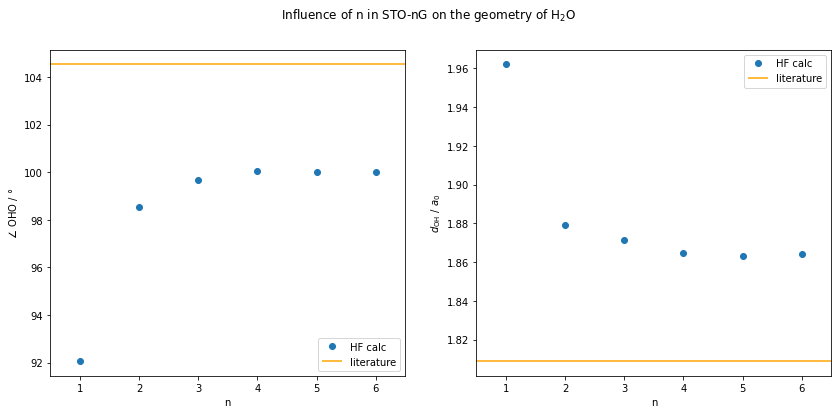

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6] # to make it larger in jupyter notebook

fig, ax = plt.subplots(1,2)

ax[0].plot(ngs, angles, 'o', label='HF calc')
ax[0].set_xlim([np.min(ngs)-0.5, np.max(ngs)+0.5])
ax[0].hlines(104.52, *ax[0].get_xlim(), 'orange', label='literature')
ax[0].set_xlabel('n')
ax[0].set_ylabel('$\\angle$ OHO / °')
ax[0].set_xticks(ngs)
ax[0].legend(loc='lower right')

ax[1].plot(ngs, bond_lengths, 'o', label='HF calc')
ax[1].set_xlim([np.min(ngs)-0.5, np.max(ngs)+0.5])
ax[1].hlines(1.809, *ax[1].get_xlim(), 'orange', label='literature')
ax[1].set_xlabel('n')
ax[1].set_ylabel('$d_{\\mathrm{OH}}$ / $a_0$')
ax[1].set_xticks(ngs)
ax[1].legend()

fig.suptitle('Influence of n in STO-nG on the geometry of H$_2$O')
